# Libraries & Functions

In [1]:
'''Math & Data Libraries'''
import numpy as np
import pandas as pd

In [2]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set_style("whitegrid", {"grid.color": "0.7", "axes.edgecolor": "0.2"})
color_palette = ["#FF8853", "#FFE174", "#007597", "#C1C36D", "#00A697", "#BC97E0", "#ffc0bf"] #[ "#007597", "#FF8853", "#C1C36D", "#FFE174","#00A697", "#BC97E0", "#ffc0bf"]
sns.set_palette(sns.color_palette(color_palette))

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

font = {'family': 'serif',
        'color':  '#333333',
        'weight': 'normal',
        'size': 12,
        }

In [4]:
import cmasher as cmr
from matplotlib.colors import ListedColormap
import matplotlib
cmap = cmr.ember #cmr.amber
c = 0.25
n = 100
cmap = ListedColormap((1. - c) * cmap(np.linspace(0., 1., n)) + c * np.ones((n, 4)))

In [5]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))# + [100]


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [6]:
cmap_dict = {}
for i in range(7):
    test_color_rgb = hex_to_rgb(color_palette[i])
    N = 256
    test_color_map = np.ones((N, 4))
    top = 1
    test_color_map[:, 0] = np.linspace(test_color_rgb[0]/256, test_color_rgb[0]/256, N) # R = 255
    test_color_map[:, 1] = np.linspace(test_color_rgb[1]/256, test_color_rgb[1]/256, N) # G = 232
    test_color_map[:, 2] = np.linspace(test_color_rgb[2]/256, test_color_rgb[2]/256, N)  # B = 11
    test_color_map[:, 3] = np.linspace(0.3, 1, N)  # B = 11

    cmap_dict[i] = ListedColormap(test_color_map)

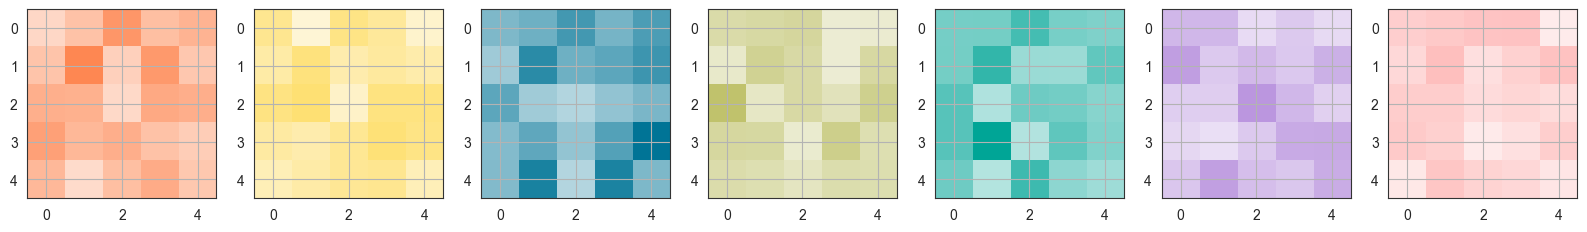

In [7]:
fig, ax = plt.subplots(figsize = (20,4), ncols = 7)
for i in range(0,7):
    ax[i].imshow(np.random.normal(0, 1, (5,5)), cmap = cmap_dict[i])
    # ax[0].colorbar()
plt.show()

# Result Data

In [8]:
df_results_POWO = pd.read_excel(f"Results//POWO_Numerical_Predictions.xlsx")
df_results_POWO_CustomBERT = pd.read_excel(f"Results//POWO_Numerical_Predictions_CustomBERT.xlsx")

In [9]:
df_results_POWO[df_results_POWO_CustomBERT.columns[-12:]] = df_results_POWO_CustomBERT[df_results_POWO_CustomBERT.columns[-12:]]

In [10]:
df_dict = {}
df_dict["POWO"] = df_results_POWO

# Visualizations

In [11]:
def draw_results(df_res, dataset, model, focus_name, focus_code, threshold = 0, cmap = cmap, scatter_color = "black", visualize = True):
    plt.suptitle(dataset + " " + model + " " + focus_name + " QA Predictions with a Threshold = " + str(threshold))
    mask = df_res[focus_code].notna()
    N_total = len(df_res)
    df_res = df_res[mask]
    
    pred_mask = (df_res[focus_code + "_" + "Predictions_" + model].notna())*(df_res[focus_code + "_" + "Predictions_" + model]!=-1)#*df_res[focus_code].notna()
    score_test = df_res[focus_code + "_" + "Scores_" + model].values[pred_mask]
    
    df = pd.DataFrame()
    df["Data_Orig"] = df_res[focus_code].values[pred_mask].astype(float)
    df["Predictions_Orig"] = df_res[focus_code + "_" + "Predictions_" + model].values[pred_mask].astype(float)
    df["Score"] = score_test
    df["Above Threshold"] = score_test>=threshold

    df = df[df["Predictions_Orig"]>0]
    
    df["Data_Log"] = np.log(df["Data_Orig"])
    df["Predictions_Log"] = np.log(df["Predictions_Orig"])
    
    scaler = MinMaxScaler()
    df["Data"] = scaler.fit_transform(df["Data_Log"].values.reshape(-1, 1))[:, 0]
    df["Predictions"] = scaler.transform(df["Predictions_Log"].values.reshape(-1,1))[:, 0]
    
    df["Above Threshold"] = df["Above Threshold"]*(df["Predictions"]>=0)*(df["Predictions"]<=1)
    linear_regressor = LinearRegression(fit_intercept = False)
    # linear_regressor = LinearRegression(fit_intercept = True)
    X = df[df["Above Threshold"]==True]["Data"].values.reshape(-1, 1)
    y = df[df["Above Threshold"]==True]["Predictions"].values
    # Fit linear regression model of HDI on the log of CPI
    linear_regressor.fit(X, y)
    x_pred = np.linspace(-10, 10, num=200).reshape(-1, 1)
    y_pred = linear_regressor.predict(x_pred)  

    coverage = np.mean(df["Above Threshold"])
    coverage_2 = len(df["Above Threshold"])/N_total
    print(np.sum(df["Above Threshold"]), np.sum(df_res[focus_code + "_" + "Answers_" + model]!="No Number"))
    r2 = r2_score(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])
    nmae = 100 * mean_absolute_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])/np.average(df[df["Above Threshold"]==True]["Data"])
    nrmse = 100 * mean_squared_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"], squared=False)/np.average(df[df["Above Threshold"]==True]["Data"])
    lr_coef = linear_regressor.coef_[0]

    if(visualize):
        fig, ax = plt.subplots(figsize=(8,7), ncols = 1)
        plt.scatter(x = df[df["Above Threshold"]==True]["Data"], y = df[df["Above Threshold"]==True]["Predictions"], c = scatter_color, vmin = 0, s = 25, alpha = 400/df.shape[0])#0.05)
        sns.kdeplot(data = df[df["Above Threshold"]==True], x = "Data", y = "Predictions", cmap = cmap, fill = False, levels = [0.05, 0.3, 0.8, 1], label = "Kernel Density Estimation", linewidths = [2, 3, 4])
        plt.plot(np.arange(-10,10),np.arange(-10,10), linestyle = "--", color = "#555555", label="Theoretical Perfect Fit", linewidth = 3, alpha=0.4)
        plt.plot(x_pred, y_pred, linestyle = "-", color = color_palette[1], label="Regression Line", linewidth = 3, alpha=0.7)

        plt.text(0.05, 0.95, "R2: {}".format(np.round(r2, 3)), fontdict=font)
        plt.text(0.05, 0.90, "nMAE: {} %".format(np.round(nmae, 2)), fontdict=font)
        plt.text(0.05, 0.85, "Recall: {} ({})".format(np.round(coverage, 3), np.round(coverage_2, 2)), fontdict=font)
        # plt.text(0.05, 0.85, "nRMSE: {} %".format(np.round(nrmse, 2)), fontdict=font)
        # plt.text(0.05, 0.80, r'$\beta$: {}'.format(np.round(lr_coef, 2)), fontdict=font)

        plt.xlabel("Data")
        plt.ylabel("Predictions")
        plt.xlim(0,1)
        plt.ylim(0,1)
    #     plt.legend()
        print(df.shape)
        plt.show()

    return df, x_pred, y_pred

In [12]:
df_res_dict = {}
x_pred_dict = {}
y_pred_dict = {}

for focus_name, focus_code in zip(["Plant Height Max"], ["1.6.2"]):
    for i, dataset in enumerate(["POWO"]):
        for model, threshold in zip(["DistilBERT", "CustomBERT"], [0.5, 0.5]): 
            print(focus_name, dataset, model)
            df_res_dict[focus_name, dataset, model], x_pred_dict[focus_name, dataset, model], y_pred_dict[focus_name, dataset, model] = draw_results(df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:], dataset, model, focus_name, focus_code, threshold = threshold, cmap = cmap_dict[2], scatter_color = color_palette[2], visualize = False)

for focus_name, focus_code in zip(["Leaf Length Max", "Leaf Width Max"], ["4.6.2", "4.7.2"]):
    for i, dataset in enumerate(["POWO"]):
        for model, threshold in zip(["DistilBERT", "CustomBERT"], [0.5, 0.5]): 
            print(focus_name, dataset, model)
            df_res_dict[focus_name, dataset, model], x_pred_dict[focus_name, dataset, model], y_pred_dict[focus_name, dataset, model] = draw_results(df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:], dataset, model, focus_name, focus_code, threshold = threshold, cmap = cmap_dict[2], scatter_color = color_palette[2], visualize = False)

Plant Height Max POWO DistilBERT
2720 10105
Plant Height Max POWO CustomBERT
4708 10105
Leaf Length Max POWO DistilBERT
709 2548
Leaf Length Max POWO CustomBERT
1099 2548
Leaf Width Max POWO DistilBERT
948 1555
Leaf Width Max POWO CustomBERT
818 1555


<Figure size 640x480 with 0 Axes>

(8265, 8)
(8796, 8)
(1829, 8)
(2287, 8)
(1230, 8)
(1335, 8)


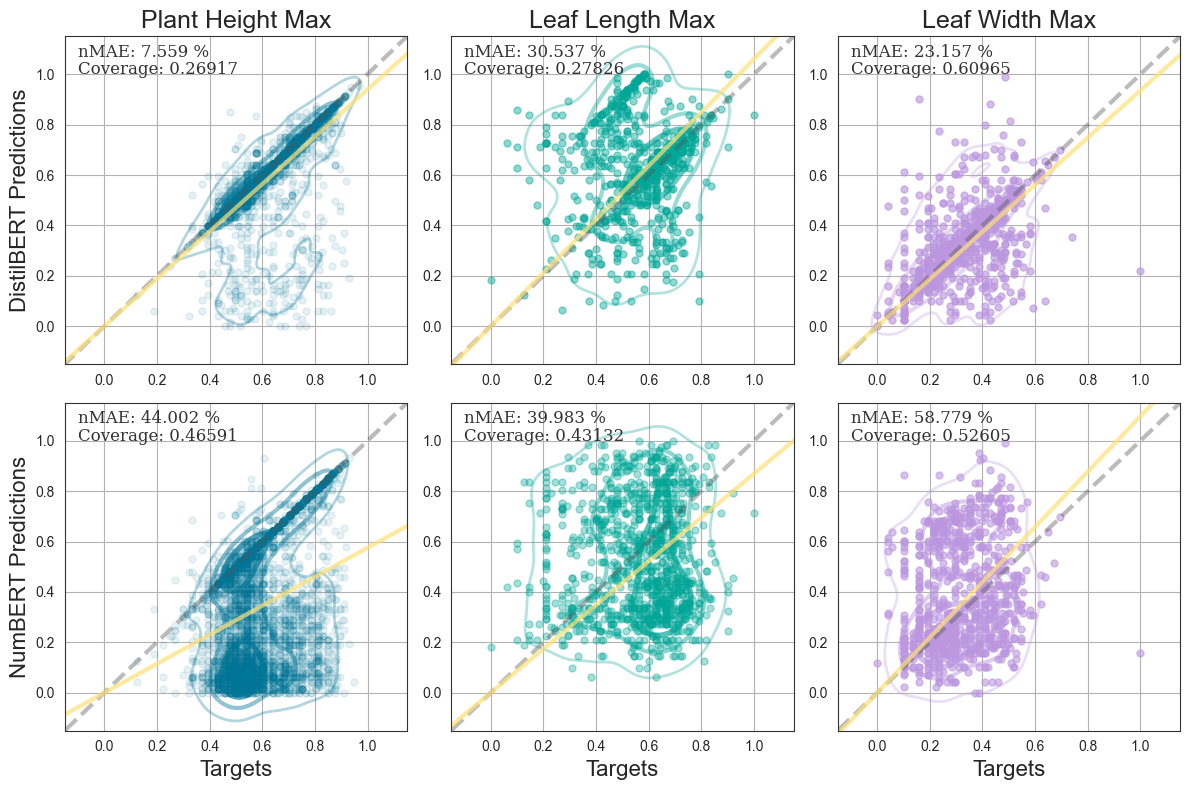

In [13]:
fig, ax = plt.subplots(figsize=(12,8), nrows = 2, ncols = 3)
for i, (focus_name, focus_code) in enumerate(zip(["Plant Height Max", "Leaf Length Max", "Leaf Width Max"], ["1.6.2", "4.6.2", "4.7.2"])):
    for dataset in ["POWO"]:
        for j, (model, threshold) in enumerate(zip(["DistilBERT", "CustomBERT"], [0.5, 0.5])): 
            
            cmap = cmap_dict[2]
            scatter_color = color_palette[2]
            if(i==1):
                cmap = cmap_dict[4]
                scatter_color = color_palette[4]
            if(i==2):
                cmap = cmap_dict[5]
                scatter_color = color_palette[5]

            plt.subplot(2, 3, 3*j+i+1)
            df = df_res_dict[focus_name, dataset, model]
            df_all = df_dict[dataset][df_dict[dataset][focus_code].notna()].iloc[:]
            x_pred = x_pred_dict[focus_name, dataset, model]
            y_pred = y_pred_dict[focus_name, dataset, model]

            coverage = np.sum(df["Above Threshold"])/(np.sum(df_all[focus_code + "_" + "Answers_" + model]!="No Number"))
            r2 = r2_score(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])
            nmae = 100 * mean_absolute_error(df[df["Above Threshold"]==True]["Data"], df[df["Above Threshold"]==True]["Predictions"])/np.average(df[df["Above Threshold"]==True]["Data"])

            plt.scatter(x = df[df["Above Threshold"]==True]["Data"], y = df[df["Above Threshold"]==True]["Predictions"], c = scatter_color, vmin = 0, s = 25, alpha = 800/df.shape[0])#0.05)
            sns.kdeplot(data = df[df["Above Threshold"]==True], x = "Data", y = "Predictions", cmap = cmap, fill = False, levels = [0.05, 0.3, 0.7, 1], label = "Kernel Density Estimation", linewidths = [2, 3, 4])
            plt.plot(np.arange(-10,10),np.arange(-10,10), linestyle = "--", color = "#555555", label="Theoretical Perfect Fit", linewidth = 3, alpha=0.4)
            plt.plot(x_pred, y_pred, linestyle = "-", color = color_palette[1], label="Regression Line", linewidth = 3, alpha=0.7)

            plt.text(-0.1, 1.07, "nMAE: {} %".format(np.round(nmae, 3)), fontdict=font)
            plt.text(-0.1, 1.0, "Coverage: {}".format(np.round(coverage, 5)), fontdict=font)
            plt.xlim(-0.15, 1.15)
            plt.ylim(-0.15, 1.15)

            print(df.shape)
            plt.xlabel("")
            plt.ylabel("")
            
            if(j==0):
                plt.title(focus_name, fontsize = 18)
            if(j==1):
                plt.xlabel("Targets", fontsize = 16)
            if(i==0):
                if(j==0):
                    plt.ylabel("DistilBERT Predictions", fontsize = 16)
                if(j==1):
                    plt.ylabel("NumBERT Predictions", fontsize = 16)
    
plt.tight_layout()
plt.show()